# JNi reaction-uniprot data clean up

In [158]:
%load_ext autoreload
%autoreload 2
from src.cheminfo_utils import load_json, save_json, get_compound_hash, get_reaction_hash, postsanitize_smiles, neutralise_charges
import pandas as pd
import csv
from collections import defaultdict
from collections import namedtuple, Counter
from rdkit import Chem
import numpy as np

In [159]:
def extract_info(entry):
    # Pull entry and uniprot ids
    if len(entry) == 3:
        rdict, pdict, uniprot = entry
        
        if uniprot == '':
            uniprot = []
        else:
            uniprot = uniprot.split(',')

    elif len(entry) == 2:
        rdict, pdict = entry
        uniprot = []

    # Smiles
    reactants, products = list(rdict.values()), list(pdict.values())
    reactants, products = sanitize(reactants, products)
    reactants, products = neutralize(reactants, products)
    sma = ".".join(sorted(reactants)) + ">>" + ".".join(sorted(products)) # Sort for consistent ordering of subs

    # Inchi (smiles if pathological) hashes
    reactants_hash_stoich = list(Counter([get_compound_hash(elt)[0] for elt in reactants]).items())
    products_hash_stoich = list(Counter([get_compound_hash(elt)[0] for elt in products]).items())
    rhash = get_reaction_hash(reactants_hash_stoich, products_hash_stoich)
    
    return rhash, uniprot, sma
    
def sanitize(reactants, products):
    return postsanitize_smiles(reactants)[0], postsanitize_smiles(products)[0]

def neutralize(reactants, products):
    reactants = [Chem.MolToSmiles(neutralise_charges(Chem.MolFromSmiles(elt, sanitize=False))) for elt in reactants]
    products = [Chem.MolToSmiles(neutralise_charges(Chem.MolFromSmiles(elt, sanitize=False))) for elt in products]
    return reactants, products

In [160]:
# Add info from JNI's "uniprot" jsons

brenda_uniprot = load_json('../data/mapping/brenda_uniprot.json')
mc_uniprot = load_json('../data/mapping/metacyc_uniprot.json')
combo_dataset = defaultdict(lambda : defaultdict(lambda : {'smarts':None, 'uniprot_ids':[]}))
bad_reactions = []

# Add metacyc first
for reaction_key, reaction_entry in mc_uniprot.items():
    rhash, uniprot_ids, smarts = extract_info(reaction_entry)
    combo_dataset[rhash][f"metacyc:{reaction_key}"]['uniprot_ids'] = uniprot_ids
    combo_dataset[rhash][f"metacyc:{reaction_key}"]['smarts'] = smarts

# Add brenda. There are multiple reactions per entry
# so we have to iterate through them all
for k, v in brenda_uniprot.items():
    n_reactions = len(v)
    n_digits = np.log10(n_reactions).astype(int) + 1

    for i in range(n_reactions):
        reaction_key = f"{k}_{i:0{n_digits}}"
        reaction_entry = v[i]
        rhash, uniprot_ids, smarts = extract_info(reaction_entry)
        combo_dataset[rhash][f"brenda:{reaction_key}"]['uniprot_ids'] = uniprot_ids
        combo_dataset[rhash][f"brenda:{reaction_key}"]['smarts'] = smarts

[10:31:49] Explicit valence for atom # 26 O, 3, is greater than permitted
[10:31:49] Explicit valence for atom # 26 O, 3, is greater than permitted
[10:31:49] Explicit valence for atom # 26 O, 3, is greater than permitted
[10:31:49] Explicit valence for atom # 26 O, 3, is greater than permitted
[10:31:50] Explicit valence for atom # 16 N, 4, is greater than permitted
[10:31:50] Explicit valence for atom # 16 N, 4, is greater than permitted
[10:31:50] Explicit valence for atom # 9 N, 4, is greater than permitted
[10:31:50] Explicit valence for atom # 9 N, 4, is greater than permitted
[10:31:50] Explicit valence for atom # 9 N, 4, is greater than permitted
[10:31:50] Explicit valence for atom # 9 N, 4, is greater than permitted
[10:31:51] Explicit valence for atom # 16 N, 4, is greater than permitted
[10:31:51] Explicit valence for atom # 25 N, 4, is greater than permitted
[10:31:51] Explicit valence for atom # 25 N, 4, is greater than permitted
[10:31:51] Explicit valence for atom # 16 

In [ ]:
# Merge in JNI's reaction jsons

db_names = ["mc_v21", "brenda", "kegg"]
mc_rxns, brenda_rxns, kegg_rxns = [load_json(f"../data/mapping/{elt}_as_is.json") for elt in db_names]
db_new_names_to_rxns = {"metacyc":mc_rxns, "brenda":brenda_rxns, "kegg":kegg_rxns}

for new_name, rxns in db_new_names_to_rxns.items():
    for reaction_key, reaction_entry in rxns.items():
        rhash, uniprot_ids, smarts = extract_info(reaction_entry)
        if rhash not in combo_dataset:
            combo_dataset[rhash][f"{new_name}:{reaction_key}"]['uniprot_ids'] = uniprot_ids
            combo_dataset[rhash][f"{new_name}:{reaction_key}"]['smarts'] = smarts
        elif f"{new_name}:{reaction_key}" not in combo_dataset[rhash]:
            combo_dataset[rhash][f"{new_name}:{reaction_key}"]['uniprot_ids'] = uniprot_ids
            combo_dataset[rhash][f"{new_name}:{reaction_key}"]['smarts'] = smarts

[01:11:38] Explicit valence for atom # 26 O, 3, is greater than permitted
[01:11:38] Explicit valence for atom # 26 O, 3, is greater than permitted
[01:11:38] Explicit valence for atom # 26 O, 3, is greater than permitted
[01:11:38] Explicit valence for atom # 26 O, 3, is greater than permitted
[01:11:39] Explicit valence for atom # 16 N, 4, is greater than permitted
[01:11:40] Explicit valence for atom # 16 N, 4, is greater than permitted
[01:11:40] Explicit valence for atom # 9 N, 4, is greater than permitted
[01:11:40] Explicit valence for atom # 9 N, 4, is greater than permitted
[01:11:40] Explicit valence for atom # 9 N, 4, is greater than permitted
[01:11:40] Explicit valence for atom # 9 N, 4, is greater than permitted
[01:11:41] Explicit valence for atom # 16 N, 4, is greater than permitted
[01:11:41] Explicit valence for atom # 25 N, 4, is greater than permitted
[01:11:41] Explicit valence for atom # 25 N, 4, is greater than permitted
[01:11:41] Explicit valence for atom # 16 

In [ ]:
# Add in mapped rules
df_opt = pd.read_csv('../data/mapping/intermediate_rules_optimized_rxns.tsv', sep='\t')
db_ids_to_rules = defaultdict(list)
rules_to_db_ids = defaultdict(list)
nrxns = 0
for index, row in df_opt.iterrows():
    rule = row["Name"]
    db_ids = row["Comments"].split(';')
    nrxns += len(db_ids)
    for elt in db_ids:
        db_ids_to_rules[elt].append(rule)

for rhash, entry in combo_dataset.items():
    for db_id in entry.keys():
        entry[db_id]['imt_rules'] = db_ids_to_rules.get(db_id, [])

In [ ]:
ct_combo = 0
degen = []
for k,v in combo_dataset.items():
    degen.append(len(v))
    for db_id in v.keys():
        ct_combo += 1

print(ct_combo)
print(sum(degen) / len(degen))

map_ct = 0
for k,v in db_ids_to_rules.items():
    if len(v) > 0:
        map_ct += 1

print(map_ct)
print(len(combo_dataset))

91034
1.773539324748193
65819
51329


In [ ]:
save_json(combo_dataset , "../data/mapping/known_rxns_w_provenance_all_info_jni.json")

# collapse multiple db entries both with and without provenance for uniprot ids

In [ ]:
%load_ext autoreload
%autoreload 2
from src.cheminfo_utils import load_json, save_json, get_compound_hash, get_reaction_hash, postsanitize_smiles, neutralise_charges
import pandas as pd
import csv
from collections import defaultdict
from collections import namedtuple, Counter
from rdkit import Chem
from rdkit.Chem import AllChem
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
combo_dataset = load_json("../data/mapping/known_rxns_w_provenance_all_info_jni.json")

In [ ]:
'''
Combine multiple db entries under single rhash
i.e., combine their imt_rules, smarts into one.

In rare cases where inconsistent smarts, rules
or both under single rhash (<1% due mainly to tautomeric
differences not captured when I hash first inchi segment),
take subset of db entries with imt rules, then take most common
SMARTS / tautomer form. Bring all uniprot ids along
''' 
folded_dataset = defaultdict(lambda : {'smarts':None, 'imt_rules':None, 'uniprot_ids':None})


# Get problem entries
bad_smarts = set()
bad_rules = set()

for rhash, entry in combo_dataset.items():
    for i, db_entry in enumerate(entry.values()):
        if i == 0:
            first_smarts = db_entry['smarts']
            first_rules = db_entry['imt_rules']

        elif first_smarts != db_entry['smarts']:
            bad_smarts.add(rhash)

        elif first_rules != db_entry['imt_rules']:
            bad_rules.add(rhash)

print(len(bad_smarts))
print(len(bad_rules))
print(len(combo_dataset))

bad_db_entries = bad_smarts | bad_rules


for rhash, entry in combo_dataset.items():
    if rhash not in bad_db_entries:
        uids = {}
        for i, (db_id, db_entry) in enumerate(entry.items()):
            if i == 0:
                folded_dataset[rhash]['smarts'] = db_entry['smarts']
                folded_dataset[rhash]['imt_rules'] = db_entry['imt_rules']

            if len(db_entry['uniprot_ids']) > 0:
                uids[db_id] = db_entry['uniprot_ids']

        folded_dataset[rhash]['uniprot_ids'] = uids

    elif any([len(v['imt_rules']) > 0 for v in entry.values()]):
        with_rules = [v['smarts'] for v in entry.values() if len(v['imt_rules'])]
        top_smarts = sorted(Counter(with_rules).items(), key=lambda x: x[1])[0][0]
        
        rules = []
        for v in entry.values():
            if v['smarts'] == top_smarts:
                rules += v['imt_rules']

        uids = {k: v['uniprot_ids'] for k,v in entry.items()}

        folded_dataset[rhash]['smarts'] = top_smarts
        folded_dataset[rhash]['imt_rules'] = rules
        folded_dataset[rhash]['uniprot_ids'] = uids
    
    else:
        with_rules = [v['smarts'] for v in entry.values()]
        top_smarts = sorted(Counter(with_rules).items(), key=lambda x: x[1])[0][0]
        
        rules = []
        for v in entry.values():
            if v['smarts'] == top_smarts:
                rules += v['imt_rules']

        uids = {k: v['uniprot_ids'] for k,v in entry.items()}

        folded_dataset[rhash]['smarts'] = top_smarts
        folded_dataset[rhash]['imt_rules'] = rules
        folded_dataset[rhash]['uniprot_ids'] = uids

491
422
51329


In [ ]:
# Check at least that you put something in every entry

for k,v in folded_dataset.items():
    try:
        assert type(v['smarts']) == str
        assert type(v['imt_rules']) == list
        assert type(v['uniprot_ids']) == dict
    except:
        print(k)


    for db_id, unis in v['uniprot_ids'].items():
        try:
            assert type(unis) == list
        except:
            print(k)

In [ ]:
save_json(folded_dataset , "../data/mapping/known_rxns_w_uniprot_provenance_jni.json")

In [61]:
'''
Finally, club all uniprot ids into one set
per reaction entry
'''

folded_dataset = load_json("../data/mapping/known_rxns_w_uniprot_provenance_jni.json")

no_provenance = defaultdict(lambda : {'smarts':None, 'imt_rules':None, 'uniprot_ids':None, 'db_ids':None})
for rhash, entry in folded_dataset.items():
    dbids = set()
    uids = set()
    for dbid, uilist in entry['uniprot_ids'].items():
        dbids.add(dbid)
        for elt in uilist:
            uids.add(elt)

    uids = list(uids)
    dbids = list(dbids)

    no_provenance[rhash]['smarts'] = folded_dataset[rhash]['smarts']
    no_provenance[rhash]['imt_rules'] = folded_dataset[rhash]['imt_rules']
    no_provenance[rhash]['uniprot_ids'] = uids
    no_provenance[rhash]['db_ids'] = dbids

all_uniprot_ids = set()

for k,v in no_provenance.items():
    for elt in v['uniprot_ids']:
        all_uniprot_ids.add(elt)

print(len(all_uniprot_ids))

save_json(no_provenance, '../data/mapping/known_rxns_jni.json')

with open("../data/mapping/all_uniprot_ids_from_known_rxns.txt", 'w') as f:
    for elt in all_uniprot_ids:
        f.write(elt + '\n')

158917


# validate josephs uniprot ids

In [1]:
%load_ext autoreload
%autoreload 2
from src.cheminfo_utils import load_json, save_json, get_compound_hash, get_reaction_hash, postsanitize_smiles, neutralise_charges
from src.post_processing import Enzyme, DatabaseEntry
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdFMCS
from collections import Counter, defaultdict
from copy import deepcopy
from itertools import permutations
from tqdm import tqdm
import logging
import pickle

def sanitize(reactants, products):
    return postsanitize_smiles(reactants)[0], postsanitize_smiles(products)[0]

def neutralize(reactants, products):
    reactants = [Chem.MolToSmiles(neutralise_charges(Chem.MolFromSmiles(elt, sanitize=False))) for elt in reactants]
    products = [Chem.MolToSmiles(neutralise_charges(Chem.MolFromSmiles(elt, sanitize=False))) for elt in products]
    return reactants, products

def ct_any_ids(known_rxns):
    n_rxns = len(known_rxns)
    n_any_ids = 0
    for k,v in known_rxns.items():
        if v['uniprot_ids']:
            n_any_ids += 1

    return n_any_ids, n_rxns

# def count_atoms(smi_str):
#     '''
#     Count atoms in provided smile string and
#     return dict of element:count pairs.
#     '''
#     # Single letter elt dict w lowercase rpts for aromatics
#     one_letter_elts = {'B':0, 'C':0, 'N':0, 'O':0,
#                         'F':0, 'P':0, 'S':0, 'I':0,
#                         'W':0, 'c':0, 'n':0, 'o':0,
#                         's':0}
    
#     aromatic_elts = ['c', 'n', 'o', 's'] # Keep track of aromatic elts
    
#     # Two letter elements
#     two_letter_elts = {'Li':0, 'Be':0, 'Ne':0, 'Na':0, 'Mg':0,
#                         'Al':0, 'Cl':0, 'Ca':0, 'Fe':0,'Ni':0,
#                         'Zn':0, 'Br':0, 'Te':0, 'As':0, 'Sb':0,
#                         'Cu':0}

#     # Count single letter elements...
#     # use Counter for single letter elts
#     single_elt_cts = Counter(one_letter_elts)
#     single_elt_cts.update(smi_str)
#     temp = {} # To replace one_letter_elts
#     for k in one_letter_elts.keys():
#         temp[k] = single_elt_cts[k]

#     # Combine aromatic counts
#     for elt in aromatic_elts:
#         temp[elt.upper()] = temp[elt.upper()] + temp[elt]
#         temp.pop(elt) # Remove lowercase keys after done w em

#     # Count two letter elements...
#     # use .count() for two letter elts
#     for k in two_letter_elts.keys():
#         two_letter_elts[k] = smi_str.count(k)

#     cts = {**temp, **two_letter_elts} # Combine one, two letter cts
#     return cts

# def is_balanced(smarts):
#     '''
#     Returns whether a reaction is balanced.
#     Args:
#         - rxn: list of dicts w/ [{react1:smi1, }, {prod1:smi1, }]
#     '''
#     rxn = smarts_to_sub_smiles(smarts)
#     side_cts = [count_atoms(''), count_atoms('')]
#     for i, side in enumerate(rxn):
#         for cpd in side:
#             cpd_cts = count_atoms(cpd)
#             for k in side_cts[i].keys():
#                 side_cts[i][k] += cpd_cts[k]

#     diff_vec = [side_cts[0][k] - side_cts[1][k] for k in side_cts[0].keys()]
#     balanced = all([elt == 0 for elt in diff_vec])
#     return balanced

In [2]:
# Load kwown reactions and uniprot entries

known_rxns = load_json("../data/mapping/known_rxns_jni.json")
jni_up = load_json("../data/mapping/jni_uniprot.json")


20850 / 51329 have any uniprot ids


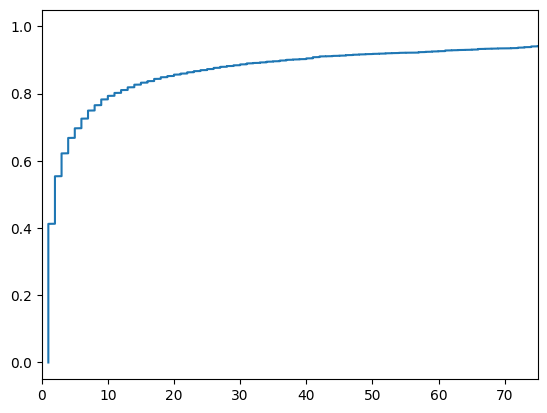

In [3]:
# Count how many uni ids per rhash before validation

pre_val_uni_ct = {k: len(v['uniprot_ids']) for k,v in known_rxns.items()}

pre_val_w_any, n_rxns = ct_any_ids(known_rxns)
print(f"{pre_val_w_any} / {n_rxns} have any uniprot ids")

xcdf_pre_val = sorted([elt for elt in pre_val_uni_ct.values() if elt > 0])
ycdf_pre_val = np.arange(len(xcdf_pre_val)) / len(xcdf_pre_val)

plt.plot(xcdf_pre_val, ycdf_pre_val)
plt.xlim(0,75)
plt.show()

In [4]:
# Assemble rhea reactions
rhea_smarts = pd.read_csv("../data/mapping/rhea-reaction-smiles.tsv", sep='\t', header=None, names=['rhea_id', 'smarts'])
rhea_directions = pd.read_csv("../data/mapping/rhea-directions.tsv", sep='\t')
rhea_smarts.head()

,rhea_id,smarts
0,10001,CCCCC(N)=O.[H]O[H]>>CCCCC(=O)[O-].[H][N+]([H])...
1,10002,CCCCC(=O)[O-].[H][N+]([H])([H])[H]>>CCCCC(N)=O...
2,10005,S=C=NCC1=CC=CC=C1>>N#CSCC1=CC=CC=C1
3,10006,N#CSCC1=CC=CC=C1>>S=C=NCC1=CC=CC=C1
4,10009,*N[C@@H](CS)C(*)=O.*N[C@@H](CS)C(*)=O.*OO>>*N[...


In [5]:
# See what types of rhea ids I got

rhea_ids_from_up = set()
master_ids = set(rhea_directions.loc[:, "RHEA_ID_MASTER"].values)
lr_ids = set(rhea_directions.loc[:, "RHEA_ID_LR"].values)
rl_ids = set(rhea_directions.loc[:, "RHEA_ID_RL"].values)
bi_ids = set(rhea_directions.loc[:, "RHEA_ID_BI"].values)
ids_w_sma = set(rhea_smarts.loc[:, 'rhea_id'].values)
other_ids = set()


for k,v in known_rxns.items():
    for uid in v['uniprot_ids']:
        if uid in jni_up:
            for rid in jni_up[uid]['rhea_ids']:
                rid = int(rid.split(':')[-1])
                rhea_ids_from_up.add(rid)

                if (rid not in master_ids) and (rid not in lr_ids) and (rid not in rl_ids) and (rid not in bi_ids) and (rid not in ids_w_sma):
                    other_ids.add(rid)

print(f"total needed: {len(rhea_ids_from_up)}, master: {len(master_ids)}, LR: {len(lr_ids)}, RL: {len(rl_ids)}, BI: {len(bi_ids)}, Other: {len(other_ids)}")

total needed: 7950, master: 16270, LR: 16270, RL: 16270, BI: 16270, Other: 184


In [6]:
print(len(master_ids & ids_w_sma), len(bi_ids & ids_w_sma), len(ids_w_sma - (lr_ids | rl_ids)))
'''
For all rows in rhea directions
    Check if lr and rl ids in ids with sma
    If both: get sma, 
    elif one: get sma, reverse it
    else continue
    put in tuple, enter in dict under all ids
'''
def smarts_to_sub_smiles(smarts):
    reactants, products = smarts.split(">>")
    reactants = reactants.split('.')
    products = products.split('.')
    return reactants, products

def sub_smiles_to_smarts(reactants, products):
    sma = ".".join(reactants) + '>>' + ".".join(products)
    return sma

def get_rhash(reactants, products):
    reactants_hash_stoich = list(Counter([get_compound_hash(elt)[0] for elt in reactants]).items())
    products_hash_stoich = list(Counter([get_compound_hash(elt)[0] for elt in products]).items())
    rhash = get_reaction_hash(reactants_hash_stoich, products_hash_stoich)
    return rhash

def get_stoichless_rhash(reactants, products):
    reactants_hash_stoich = list(Counter(set([get_compound_hash(elt)[0] for elt in reactants])).items())
    products_hash_stoich = list(Counter(set([get_compound_hash(elt)[0] for elt in products])).items())
    rhash = get_reaction_hash(reactants_hash_stoich, products_hash_stoich)
    return rhash

# Multiple rhea ids will map to 
# same tuple of reaction info
rhea_id_to_rhashes = {}
rhea_id_to_stoichless_rhashes = {}
rhea_id_to_smarts = {}
for _, row in rhea_directions.iterrows():
    lrid, rlid = row["RHEA_ID_LR"], row["RHEA_ID_RL"]
    if lrid in ids_w_sma and rlid in ids_w_sma:
        lr_sma = rhea_smarts.loc[rhea_smarts['rhea_id'] == lrid, 'smarts'].values[0]
        rl_sma = rhea_smarts.loc[rhea_smarts['rhea_id'] == rlid, 'smarts'].values[0]
    elif lrid in ids_w_sma:
        lr_sma = rhea_smarts.loc[rhea_smarts['rhea_id'] == lrid, 'smarts'].values[0]
        rl_sma = ">>".join([lr_sma.split('>>')[1], lr_sma.split('>>')[0]])
    elif rlid in ids_w_sma:
        rl_sma = rhea_smarts.loc[rhea_smarts['rhea_id'] == rlid, 'smarts'].values[0]
        lr_sma = ">>".join([lr_sma.split('>>')[1], lr_sma.split('>>')[0]])
    else:
        continue

    san_sma = []
    rhashes = []
    stoichless_rhashes = []
    for sma in [lr_sma, rl_sma]:
        reactants, products = smarts_to_sub_smiles(sma)
        reactants = [elt for elt in reactants if elt != '[H+]'] # Remove protons
        products = [elt for elt in products if elt != '[H+]']
        reactants, products = sanitize(reactants, products)
        reactants, products = neutralize(reactants, products)
        sma = ".".join(reactants) + '>>' + ".".join(products)
        rhash = get_rhash(reactants, products)
        stoichless_rhash = get_stoichless_rhash(reactants, products)
        san_sma.append(sma)
        rhashes.append(rhash)
        stoichless_rhashes.append(stoichless_rhash)

        for id in row.to_list():
            rhea_id_to_rhashes[id] = tuple(rhashes)
            rhea_id_to_stoichless_rhashes[id] = tuple(stoichless_rhashes)
            rhea_id_to_smarts[id] = tuple(san_sma)

0 0 0


[16:22:49] Can't kekulize mol.  Unkekulized atoms: 2 4 5 11
[16:22:49] Can't kekulize mol.  Unkekulized atoms: 2 4 5 11
[16:22:49] Can't kekulize mol.  Unkekulized atoms: 2 4 5 11
[16:22:49] Can't kekulize mol.  Unkekulized atoms: 2 4 5 11
[16:22:49] WARNING: not removing hydrogen atom with dummy atom neighbors
[16:22:49] WARNING: not removing hydrogen atom with dummy atom neighbors
[16:22:49] WARNING: not removing hydrogen atom with dummy atom neighbors
[16:22:49] WARNING: not removing hydrogen atom with dummy atom neighbors
[16:22:49] WARNING: not removing hydrogen atom with dummy atom neighbors
[16:22:49] WARNING: not removing hydrogen atom with dummy atom neighbors
[16:22:49] WARNING: not removing hydrogen atom with dummy atom neighbors
[16:22:49] WARNING: not removing hydrogen atom with dummy atom neighbors
[16:22:50] WARNING: not removing hydrogen atom with dummy atom neighbors
[16:22:50] WARNING: not removing hydrogen atom with dummy atom neighbors
[16:22:50] WARNING: not removi

In [7]:
# Are they off by stoich only?

# Re-hash known reactions without stoich
for k, v in known_rxns.items():
    reactants, products = smarts_to_sub_smiles(v['smarts'])
    stoichless_rhash = get_stoichless_rhash(reactants, products)
    v['stoichless_rhash'] = stoichless_rhash
    

[16:25:36] Can't kekulize mol.  Unkekulized atoms: 3 5 6 12
[16:25:36] Can't kekulize mol.  Unkekulized atoms: 3 5 6 12
[16:25:36] Can't kekulize mol.  Unkekulized atoms: 2 4 5 11
[16:25:36] Can't kekulize mol.  Unkekulized atoms: 2 4 5 11
[16:25:36] Can't kekulize mol.  Unkekulized atoms: 1 5 6 7 8 9
[16:25:36] Can't kekulize mol.  Unkekulized atoms: 1 5 6 7 8 9
[16:25:36] Can't kekulize mol.  Unkekulized atoms: 1 5 6 7 8 9
[16:25:36] Can't kekulize mol.  Unkekulized atoms: 1 5 6 7 8 9
[16:25:37] Can't kekulize mol.  Unkekulized atoms: 16 20 23 24 25 26 27 28 30 31
[16:25:37] Can't kekulize mol.  Unkekulized atoms: 2 5 6 7 8 9 10 12 13 24
[16:25:37] Can't kekulize mol.  Unkekulized atoms: 2 5 6 7 8 9 10 12 13 24
[16:25:37] Can't kekulize mol.  Unkekulized atoms: 16 20 23 24 25 26 27 28 30 31
[16:25:37] Can't kekulize mol.  Unkekulized atoms: 1 5 6 7 8 9
[16:25:37] Can't kekulize mol.  Unkekulized atoms: 1 5 6 7 8 9
[16:25:38] Can't kekulize mol.  Unkekulized atoms: 1 5 6 7 8 9
[16:25:

In [8]:
# Load mcs similarity scores indexed in same way as side_by_side
with open("../data/mapping/mcs_similarity_known_rhea_rxn_pairs.pkl", 'rb') as f:
    mcs_scores = pickle.load(f)

In [9]:
# Filter known reactions' uniprot ids

'''
Filters
'''
in_uniprot = lambda x : x in jni_up # Whether I found uniprot id in uniprot
has_rxn = lambda x : len(jni_up[x]['rhea_ids']) > 0 # Whether a found uniprot entry had rhea reactions at all

def is_rhash_equivalent(x, putative_rhash, jni_up, rhea_id_to_rhashes):
    '''
    Do any rhea reaction rhashes form up entry match the one from joseph's
    known reactions?
    '''
    rheas = [int(elt.split(":")[1]) for elt in jni_up[x]['rhea_ids']]
    bool_list = [putative_rhash in rhea_id_to_rhashes.get(elt, []) for elt in rheas]
    return any(bool_list)

def is_stoichless_rhash_equivalent(x, putative_rhash, jni_up, rhea_id_to_rhashes):
    '''
    Do any rhea reaction rhashes form up entry match the one from joseph's
    known reactions?
    '''
    rheas = [int(elt.split(":")[1]) for elt in jni_up[x]['rhea_ids']]
    bool_list = [putative_rhash in rhea_id_to_rhashes.get(elt, []) for elt in rheas]
    return any(bool_list)

def is_mcs_score_equivalent(x, putative_rhash, jni_up, mcs_scores, threshold):
    rheas = [int(elt.split(":")[1]) for elt in jni_up[x]['rhea_ids']]
    rhea_hashes = [rhea_id_to_rhashes[elt] for elt in rheas if elt in rhea_id_to_rhashes]
    bool_list = [mcs_scores.get((putative_rhash, rhea_hash), 0) >= threshold for rhea_hash in rhea_hashes]
    return any(bool_list)

def filter_known_rxns_uniprot(filter_fcn, known_rxns, jni_up=jni_up,
                                rhea_id_to_rhashes=rhea_id_to_rhashes,
                                rhea_id_to_stoichless_rhashes=rhea_id_to_stoichless_rhashes,
                                rhea_id_to_smarts=rhea_id_to_smarts, mcs_scores=mcs_scores,
                                mcs_threshold=0.9):
    '''
    Wraparound filter dict to process known rxns entries    
    '''
    temp = deepcopy(known_rxns)
    filtered_known_rxns = {}
    for k,v in tqdm(temp.items(), desc='known rxns'):
        if filter_fcn is is_rhash_equivalent:
            _filter_fcn = lambda x: filter_fcn(x, k, jni_up, rhea_id_to_rhashes) # Pass putative rhash, k and dicts

        elif filter_fcn is is_stoichless_rhash_equivalent:
            _filter_fcn = lambda x: filter_fcn(x, v['stoichless_rhash'], jni_up, rhea_id_to_stoichless_rhashes) # Pass stoichless putative rhash
        elif filter_fcn is is_mcs_score_equivalent:
            _filter_fcn = lambda x: filter_fcn(x, k, jni_up, mcs_scores, mcs_threshold)
        else:
            _filter_fcn = filter_fcn

        ds_uids = list(filter(_filter_fcn, v['uniprot_ids']))
        filtered_known_rxns[k] = v
        filtered_known_rxns[k]['uniprot_ids'] = ds_uids
    return filtered_known_rxns

known_rxns_found_uid = filter_known_rxns_uniprot(in_uniprot, known_rxns)
n_any, n_rxns = ct_any_ids(known_rxns_found_uid)
print(f"{n_any} / {n_rxns} rxns with uniprot ids I found in uniprot")

known_rxns_found_rhea_rxn = filter_known_rxns_uniprot(has_rxn, known_rxns_found_uid)
n_any, n_rxns = ct_any_ids(known_rxns_found_rhea_rxn)
print(f"{n_any} / {n_rxns} rxns with uniprot with reactions")

known_rxns_stoichless_equivalent = filter_known_rxns_uniprot(is_stoichless_rhash_equivalent, known_rxns_found_rhea_rxn)
n_any, n_rxns = ct_any_ids(known_rxns_stoichless_equivalent)
print(f"{n_any} / {n_rxns} rxns with stoichless rhash equivalence")

known_rxns_w_rhash_eq = filter_known_rxns_uniprot(is_rhash_equivalent, known_rxns_found_rhea_rxn)
n_any, n_rxns = ct_any_ids(known_rxns_w_rhash_eq)
print(f"{n_any} / {n_rxns} rxns with uniprot with rhash equivalent rhea reactions")

known rxns: 100%|██████████| 51329/51329 [00:00<00:00, 447047.18it/s]


19568 / 51329 rxns with uniprot ids I found in uniprot


known rxns: 100%|██████████| 51329/51329 [00:00<00:00, 258158.14it/s]


15289 / 51329 rxns with uniprot with reactions


known rxns: 100%|██████████| 51329/51329 [00:00<00:00, 78790.21it/s]


5977 / 51329 rxns with stoichless rhash equivalence


known rxns: 100%|██████████| 51329/51329 [00:00<00:00, 88165.80it/s]

5973 / 51329 rxns with uniprot with rhash equivalent rhea reactions


In [10]:
# Get known rxns w uniprot with rhea rxns but which were
# not matched by rhash
unmatched_by_rhash = {}
for k in known_rxns.keys():
    if known_rxns_found_rhea_rxn[k]['uniprot_ids'] and not known_rxns_w_rhash_eq[k]['uniprot_ids']:
        unmatched_by_rhash[k] = known_rxns_found_rhea_rxn[k]

print(len(unmatched_by_rhash))

# Arrange remaining rhea rxn ids
# under key of known (reaction hash, (rhea_rxn hashes))
side_by_side = defaultdict(list)
rhea_rhashes_to_smarts = defaultdict(set)
for key, kr in unmatched_by_rhash.items():
    for uid in kr['uniprot_ids']:
        for rhea in jni_up[uid]['rhea_ids']:
            rhea = int(rhea.split(":")[1])
            if rhea in rhea_id_to_rhashes:
                rhea_hash = rhea_id_to_rhashes[rhea]
                rhea_smarts = rhea_id_to_smarts[rhea]
                side_by_side[(key, rhea_hash)].append(rhea)
                rhea_rhashes_to_smarts[rhea_hash].add(rhea_smarts[0])
                rhea_rhashes_to_smarts[rhea_hash].add(rhea_smarts[1])
                


rhea_rhashes_to_id = defaultdict(list)
for k,v in rhea_id_to_rhashes.items():
    rhea_rhashes_to_id[v].append(k)

9316


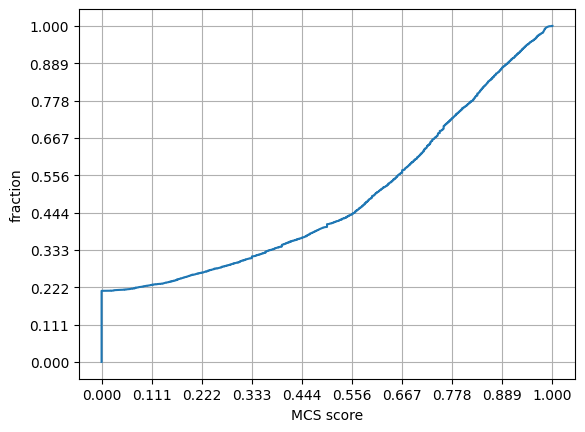

In [11]:
hashes, scores = zip(*sorted(mcs_scores.items(), key=lambda x: x[1], reverse=True))
asc_scores = sorted(scores)
cdf = np.arange(1, len(asc_scores) + 1) / len(asc_scores)
fig, ax = plt.subplots()
ax.plot(asc_scores, cdf)
ax.set_ylabel('fraction')
ax.set_xlabel('MCS score')
ax.grid()
ax.set_xticks(np.linspace(0, 1, num=10))
ax.set_yticks(np.linspace(0, 1, num=10))
plt.show()

In [12]:
# Spot check

i = 0

In [13]:
kr_sma = known_rxns[hashes[i][0]]['smarts']
rhea_sma = list(rhea_rhashes_to_smarts[hashes[i][1]])
print(f"i = {i}")
print(scores[i])
print(kr_sma)
for elt in rhea_sma:
    print(elt)
print(known_rxns[hashes[i][0]]['imt_rules'])
i+=1

i = 0
1.0
Nc1ncnc2c1ncn2C1OC(COP(=O)(O)OP(=O)(O)O)C(O)C1O.O=P(O)(O)O.[Ca]>>Nc1ncnc2c1ncn2C1OC(COP(=O)(O)OP(=O)(O)OP(=O)(O)O)C(O)C1O.O.[Ca]
Nc1ncnc2c1ncn2C1OC(COP(=O)(O)OP(=O)(O)O)C(O)C1O.O=P(O)(O)O.[Ca+2]>>Nc1ncnc2c1ncn2C1OC(COP(=O)(O)OP(=O)(O)OP(=O)(O)O)C(O)C1O.[Ca+2].O
Nc1ncnc2c1ncn2C1OC(COP(=O)(O)OP(=O)(O)OP(=O)(O)O)C(O)C1O.[Ca+2].O>>Nc1ncnc2c1ncn2C1OC(COP(=O)(O)OP(=O)(O)O)C(O)C1O.O=P(O)(O)O.[Ca+2]
[]


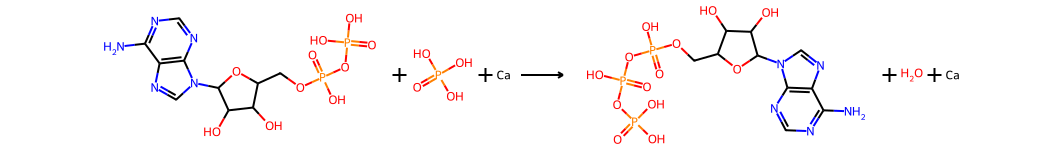

In [14]:
# print(f"Balanced: {is_balanced(kr_sma)}")
AllChem.ReactionFromSmarts(kr_sma, useSmiles=True)


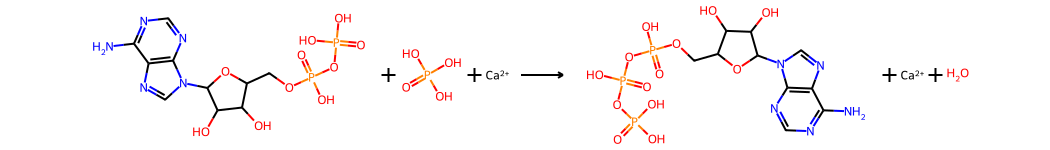

In [15]:
# print(f"Balanced: {is_balanced(rhea_sma[0])}")
AllChem.ReactionFromSmarts(rhea_sma[0], useSmiles=True)

In [16]:
# Filter by some threshold on validation score, print stats

threshold = 0.90
len(mcs_scores), len(side_by_side)

known_rxns_w_mcs_eq = filter_known_rxns_uniprot(is_mcs_score_equivalent, unmatched_by_rhash, mcs_threshold=threshold)
n_any, n_rxns = ct_any_ids(known_rxns_w_mcs_eq)
print(f"{n_any} / {n_rxns} rxns with uniprot with rhash equivalent rhea reactions")

known rxns: 100%|██████████| 9316/9316 [00:00<00:00, 26072.91it/s]

2583 / 9316 rxns with uniprot with rhash equivalent rhea reactions


In [17]:
mcs_90 = [k for k,v in known_rxns_w_mcs_eq.items() if v['uniprot_ids']]

In [171]:
# mcs_95 = [k for k,v in known_rxns_w_mcs_eq.items() if v['uniprot_ids']]

In [18]:
def kr_uid_to_mcs_score(kr_hash, uid, jni_up=jni_up, mcs_scores=mcs_scores):
    rheas = [int(elt.split(":")[1]) for elt in jni_up[uid]['rhea_ids']]
    rhea_hashes = [rhea_id_to_rhashes[elt] for elt in rheas if elt in rhea_id_to_rhashes]
    scores = [mcs_scores.get((kr_hash, rhea_hash), 0) for rhea_hash in rhea_hashes]
    return max(scores)

# Compile known reactions from rhash and mcs validated
# into validated known reactions dict with validation scores
known_rxns_validated_enzymes = {}

# This dict has all the original known reactions but only
# uniprot that have been rhash validated
for k,v in known_rxns_w_rhash_eq.items():
    known_rxns_validated_enzymes[k] = {'smarts':v['smarts'], 'imt_rules':v['imt_rules'], 'enzymes':None, 'db_entries':None}

    enzymes = []
    for uid in v['uniprot_ids']:
        up_entry = jni_up[uid]
        e = Enzyme(uniprot_id=uid, sequence=up_entry.get('sequence', None), reviewed=up_entry.get('reviewed', None),
                    existence=up_entry.get('existence', None), organism=up_entry.get('organism', None), validation_score=1.0)
        enzymes.append(e)

    db_entries = [DatabaseEntry(x.split(':')[0], x.split(":")[1]) for x in v['db_ids']]

    known_rxns_validated_enzymes[k]['enzymes'] = enzymes
    known_rxns_validated_enzymes[k]['db_entries'] = db_entries

# This dict has only known reactions that were not rhash
# validated with uniprot that were not rhash validated
# but did have rhea rxns in uniprot entry
for k,v in known_rxns_w_mcs_eq.items():
    enzymes = []
    for uid in v['uniprot_ids']:
        val_score = kr_uid_to_mcs_score(k, uid)

        up_entry = jni_up[uid]
        e = Enzyme(uniprot_id=uid, sequence=up_entry.get('sequence', None), reviewed=up_entry.get('reviewed', None),
                    existence=up_entry.get('existence', None), organism=up_entry.get('organism', None), validation_score=val_score)
        enzymes.append(e)

    known_rxns_validated_enzymes[k]['enzymes'] += enzymes

save_json(known_rxns_validated_enzymes, '../data/mapping/known_rxns_jni_w_enzyme_validation.json')

# hifi reaction-enzyme pairs

In [109]:
import pandas as pd
import re
from src.cheminfo_utils import save_json, get_compound_hash, get_reaction_hash, postsanitize_smiles, neutralise_charges, smarts_to_sub_smiles, sub_smiles_to_smarts
from src.post_processing import Enzyme, DatabaseEntry
from rdkit import Chem
from rdkit.Chem import AllChem
from collections import Counter, defaultdict
from tqdm import tqdm

def sanitize(reactants, products):
    return postsanitize_smiles(reactants)[0], postsanitize_smiles(products)[0]

def neutralize(reactants, products):
    reactants = [Chem.MolToSmiles(neutralise_charges(Chem.MolFromSmiles(elt, sanitize=False))) for elt in reactants]
    products = [Chem.MolToSmiles(neutralise_charges(Chem.MolFromSmiles(elt, sanitize=False))) for elt in products]
    return reactants, products

def get_rhash(reactants, products):
    reactants_hash_stoich = list(Counter([get_compound_hash(elt)[0] for elt in reactants]).items())
    products_hash_stoich = list(Counter([get_compound_hash(elt)[0] for elt in products]).items())
    rhash = get_reaction_hash(reactants_hash_stoich, products_hash_stoich)
    return rhash

In [110]:
path = "../data/mapping/uniprotkb_reviewed_true_AND_proteins_wi_2024_02_29.tsv"
df = pd.read_csv(path, sep='\t')
df.set_index("Entry", inplace=True)
df.head()


,Reviewed,Protein names,Organism,Protein existence,Sequence,Catalytic activity,EC number
Entry,,,,,,,
A0A009IHW8,reviewed,2' cyclic ADP-D-ribose synthase AbTIR (2'cADPR...,Acinetobacter baumannii (strain 1295743),Evidence at protein level,MSLEQKKGADIISKILQIQNSIGKTTSPSTLKTKLSEISRKEQENA...,CATALYTIC ACTIVITY: Reaction=NAD(+) = 2'cADPR ...,3.2.2.-; 3.2.2.6
A0A023I7E1,reviewed,"Glucan endo-1,3-beta-D-glucosidase 1 (Endo-1,3...",Rhizomucor miehei,Evidence at protein level,MRFQVIVAAATITMITSYIPGVASQSTSDGDDLFVPVSNFDPKSIF...,CATALYTIC ACTIVITY: Reaction=Hydrolysis of (1-...,3.2.1.39
A0A024B7W1,reviewed,Genome polyprotein [Cleaved into: Capsid prote...,Zika virus (isolate ZIKV/Human/French Polynesi...,Evidence at protein level,MKNPKKKSGGFRIVNMLKRGVARVSPFGGLKRLPAGLLLGHGPIRM...,CATALYTIC ACTIVITY: [RNA-directed RNA polymera...,2.1.1.56; 2.1.1.57; 2.7.7.48; 3.4.21.91; 3.6.1...
A0A024SC78,reviewed,Cutinase (EC 3.1.1.74),Hypocrea jecorina (strain ATCC 56765 / BCRC 32...,Evidence at protein level,MRSLAILTTLLAGHAFAYPKPAPQSVNRRDWPSINEFLSELAKVMP...,CATALYTIC ACTIVITY: Reaction=cutin + H2O = cut...,3.1.1.74
A0A024SH76,reviewed,"Exoglucanase 2 (EC 3.2.1.91) (1,4-beta-cellobi...",Hypocrea jecorina (strain ATCC 56765 / BCRC 32...,Evidence at protein level,MIVGILTTLATLATLAASVPLEERQACSSVWGQCGGQNWSGPTCCA...,CATALYTIC ACTIVITY: Reaction=Hydrolysis of (1-...,3.2.1.91


In [111]:
# Get rhea ids for up entries

upid2rheaid = {}
pattern = r'RHEA:(\d{1,6})' # Regular expression pattern
no_matches = []

for entry, row in df.iterrows():
    cat_act = row["Catalytic activity"]
    if pd.isna(cat_act):
        no_matches.append(entry)
    else:
        matches = re.findall(pattern, cat_act)

        if len(matches) > 0:
            upid2rheaid[entry] = [int(match) for match in matches]
        else:
            no_matches.append(entry)


In [112]:
print(len(df)), print(len(upid2rheaid)), print(len(no_matches))

255081
230436
24645


(None, None, None)

In [113]:
i = 0

In [114]:
print(df.loc[no_matches[i], "Catalytic activity"])
i += 1

CATALYTIC ACTIVITY: Reaction=Hydrolysis of (1->3)-beta-D-glucosidic linkages in (1->3)-beta-D-glucans.; EC=3.2.1.39; Evidence={ECO:0000269|PubMed:34801773};


In [115]:
all_extracted_from_up = set()
for k,v in upid2rheaid.items():
    for elt in v:
        all_extracted_from_up.add(elt)

print(len(all_extracted_from_up))

19261


In [116]:
# Read in rhea reactions
rhea_smarts = pd.read_csv("../data/mapping/rhea-reaction-smiles.tsv", sep='\t', header=None, names=['rhea_id', 'smarts'])
rhea_directions = pd.read_csv("../data/mapping/rhea-directions.tsv", sep='\t')

# Map rhea ids to smarts and keep all rhea id -> up id mappings
rhea_id_to_raw_smarts = {}
rheaid2upid = defaultdict(set)
for upid, rheas in upid2rheaid.items():
    for rhea_id in rheas:

        if rhea_id in rhea_id_to_raw_smarts: # Already have rhea id in smarts dict
            rheaid2upid[rhea_id].add(upid)
        elif rhea_id in rhea_smarts["rhea_id"].values: # Rhea provides smarts under this id
            rhea_id_to_raw_smarts[rhea_id] = rhea_smarts.loc[rhea_smarts["rhea_id"] == rhea_id, "smarts"].to_list()[0]
            rheaid2upid[rhea_id].add(upid)
        elif rhea_id in rhea_directions["RHEA_ID_MASTER"].values: # Rhea lists this id as a master id
            lr = rhea_directions.loc[rhea_directions["RHEA_ID_MASTER"] == rhea_id , "RHEA_ID_LR"].to_list()[0]
            rl = rhea_directions.loc[rhea_directions["RHEA_ID_MASTER"] == rhea_id , "RHEA_ID_RL"].to_list()[0]

            if lr in rhea_id_to_raw_smarts: # Already have lr id associated with this id
                rheaid2upid[lr].add(upid)
            elif lr in rhea_smarts["rhea_id"].values: # Associated lr id has associated smarts
                rhea_id_to_raw_smarts[lr] = rhea_smarts.loc[rhea_smarts["rhea_id"] == lr, "smarts"].to_list()[0]
                rheaid2upid[lr].add(upid)
            
            if rl in rhea_id_to_raw_smarts: # Same as above but for rl
                rheaid2upid[rl].add(upid)
            elif rl in rhea_smarts["rhea_id"].values:
                rhea_id_to_raw_smarts[rl] = rhea_smarts.loc[rhea_smarts["rhea_id"] == rl, "smarts"].to_list()[0]
                rheaid2upid[rl].add(upid)

        elif rhea_id in rhea_directions["RHEA_ID_BI"].values: # Rhea lists this as bidir id, same as above elif
            lr = rhea_directions.loc[rhea_directions["RHEA_ID_BI"] == rhea_id , "RHEA_ID_LR"].to_list()[0]
            rl = rhea_directions.loc[rhea_directions["RHEA_ID_BI"] == rhea_id , "RHEA_ID_RL"].to_list()[0]

            if lr in rhea_id_to_raw_smarts:
                rheaid2upid[lr].add(upid)
            elif lr in rhea_smarts["rhea_id"].values:
                rhea_id_to_raw_smarts[lr] = rhea_smarts.loc[rhea_smarts["rhea_id"] == lr, "smarts"].to_list()[0]
                rheaid2upid[lr].add(upid)

            if rl in rhea_id_to_raw_smarts:
                rheaid2upid[rl].add(upid)
            elif rl in rhea_smarts["rhea_id"].values:
                rhea_id_to_raw_smarts[rl] = rhea_smarts.loc[rhea_smarts["rhea_id"] == rl, "smarts"].to_list()[0]
                rheaid2upid[rl].add(upid)
        
for k,v in rheaid2upid.items():
    rheaid2upid[k] = list(v)

print(len(rhea_id_to_raw_smarts))

23902


In [117]:
unique_enzymes = set()
for v in rheaid2upid.values():
    for elt in v:
        unique_enzymes.add(elt)
print(len(unique_enzymes))

216669


In [118]:
# Sanitize smarts from rhea
rhash_to_san_smarts = {}
for rhea_id, sma in rhea_id_to_raw_smarts.items():
    reactants, products = smarts_to_sub_smiles(sma)
    reactants = [elt for elt in reactants if elt != '[H+]'] # Remove protons
    products = [elt for elt in products if elt != '[H+]']
    reactants, products = sanitize(reactants, products)
    reactants, products = neutralize(reactants, products)
    san_sma = ".".join(reactants) + '>>' + ".".join(products)
    rhash = get_rhash(reactants, products)

    if rhash in rhash_to_san_smarts:
        rhash_to_san_smarts[rhash]['rhea_ids'].append(rhea_id)
    else:
        rhash_to_san_smarts[rhash] = {'smarts':san_sma, 'rhea_ids':[rhea_id]}

[07:46:50] WARNING: not removing hydrogen atom with dummy atom neighbors
[07:46:50] WARNING: not removing hydrogen atom with dummy atom neighbors
[07:46:50] WARNING: not removing hydrogen atom with dummy atom neighbors
[07:46:50] WARNING: not removing hydrogen atom with dummy atom neighbors
[07:46:50] WARNING: not removing hydrogen atom with dummy atom neighbors
[07:46:50] WARNING: not removing hydrogen atom with dummy atom neighbors
[07:46:50] WARNING: not removing hydrogen atom with dummy atom neighbors
[07:46:50] WARNING: not removing hydrogen atom with dummy atom neighbors
[07:46:50] WARNING: not removing hydrogen atom with dummy atom neighbors
[07:46:50] WARNING: not removing hydrogen atom with dummy atom neighbors
[07:46:50] WARNING: not removing hydrogen atom with dummy atom neighbors
[07:46:50] WARNING: not removing hydrogen atom with dummy atom neighbors
[07:46:52] Can't kekulize mol.  Unkekulized atoms: 1 5 6 10 11 12
[07:46:52] Can't kekulize mol.  Unkekulized atoms: 1 5 6 1

In [119]:
# Check for / construct reaction reverses
rhash2reverse = {}
for rhash, elt in rhash_to_san_smarts.items():
    found_rev = False
    smarts = elt['smarts']
    smarts_rev = ">>".join((smarts.split(">>")[1], smarts.split(">>")[0]))
    for rhash2, elt2 in rhash_to_san_smarts.items():
        smarts2 = elt2['smarts']
        if smarts_rev == smarts2:
            rhash2reverse[rhash] = rhash2
            found_rev = True
            break

    if not found_rev:
        print(rhash)
        reactants, products = smarts_to_sub_smiles(smarts_rev)
        rhash_rev = get_rhash(reactants, products)
        rhash2reverse[rhash] = rhash_rev
        rhash2reverse[rhash_rev] = rhash
        rhash_to_san_smarts[rhash_rev] = {'smarts':smarts_rev, 'rhea_ids':[]}

print(len(rhash_to_san_smarts))

20382


In [120]:
def clean_up_ec(ec_entry):
    if pd.isna(ec_entry):
        return None

    ec_entry = ec_entry.split(';')
    ec_entry = [elt.strip('.-').strip(' ') for elt in ec_entry]
    clean_ec = set()
    for elt in ec_entry:
        if len(elt.split('.')) == 4:
            clean_ec.add(elt)

    return tuple(clean_ec)

def get_enzymes_and_entries(rhashes, rhash_to_san_smarts, rheaid2upid):
    db_entries = set()
    enzymes = set()
    for rhash in rhashes:
        rhea_ids = rhash_to_san_smarts[rhash]['rhea_ids']
        for ri in rhea_ids:
            db_entries.add(DatabaseEntry(db='rhea', id=ri))
            for up in rheaid2upid[ri]:
                row = df.loc[up]
                seq = row["Sequence"]
                ext = row["Protein existence"]
                rev = row["Reviewed"]
                org = row["Organism"]
                ec = clean_up_ec(row["EC number"])
                enzymes.add(Enzyme(uniprot_id=up, sequence=seq, ec=ec, validation_score=1.0, existence=ext, reviewed=rev, organism=org))
    return list(enzymes), list(db_entries)

hifi_known_rxns = defaultdict(lambda : {'smarts':[], 'imt_rules':[], 'min_rules':[], 'enzymes':[], 'db_entries':[], 'reverse':None})
rhash_iterator = iter(rhash_to_san_smarts.keys())
key_bag = set(rhash_to_san_smarts.keys())
while key_bag:
    # Get stuff
    rhash = next(rhash_iterator)
    rhash_rev = rhash2reverse[rhash]
    smarts = rhash_to_san_smarts[rhash]['smarts']
    smarts_rev = rhash_to_san_smarts[rhash_rev]['smarts']
    enzymes, db_entries = get_enzymes_and_entries((rhash, rhash_rev), rhash_to_san_smarts, rheaid2upid)

    if not enzymes:
        print(rhash)
        print(rhash_rev)
        break

    # Set stuff
    hifi_known_rxns[rhash]['smarts'] = smarts
    hifi_known_rxns[rhash]['enzymes'] = enzymes
    hifi_known_rxns[rhash]['db_entries'] = db_entries
    hifi_known_rxns[rhash]['reverse'] = rhash_rev

    hifi_known_rxns[rhash_rev]['smarts'] = smarts_rev
    hifi_known_rxns[rhash_rev]['enzymes'] = enzymes
    hifi_known_rxns[rhash_rev]['db_entries'] = db_entries
    hifi_known_rxns[rhash_rev]['reverse'] = rhash

    # Forget stuff
    key_bag.discard(rhash)
    key_bag.discard(rhash_rev)
    
print(len(hifi_known_rxns))

20380
20380
20378
20378
20376
20376
20374
20374
20372
20372
20370
20370
20368
20368
20366
20366
20364
20364
20362
20362
20360
20360
20358
20358
20356
20356
20354
20354
20352
20352
20350
20350
20348
20348
20346
20346
20344
20344
20342
20342
20340
20340
20338
20338
20336
20336
20334
20334
20332
20332
20330
20330
20328
20328
20326
20326
20324
20324
20322
20322
20320
20320
20318
20318
20316
20316
20314
20314
20312
20312
20310
20310
20308
20308
20306
20306
20304
20304
20302
20302
20300
20300
20298
20298
20296
20296
20294
20294
20293
20291
20291
20289
20289
20287
20287
20285
20285
20283
20283
20281
20281
20279
20279
20277
20277
20275
20275
20273
20273
20271
20271
20269
20269
20267
20267
20265
20265
20263
20263
20261
20261
20259
20259
20257
20257
20255
20255
20253
20253
20251
20251
20249
20249
20247
20247
20245
20245
20243
20243
20241
20241
20239
20239
20237
20237
20235
20235
20233
20233
20231
20231
20229
20229
20227
20227
20225
20225
20223
20223
20221
20221
20219
20219
20217
20217
20215
2021

In [122]:
len(hifi_known_rxns)

20382

In [123]:
save_json(hifi_known_rxns, "../data/mapping/known_rxns_swissprot_enzymes_240310_v2.json")

In [81]:
# Overlap with JNi rhash validated
len(set([k for k,v in known_rxns_w_rhash_eq.items() if v['uniprot_ids']]) & set(hifi_known_rxns.keys()))

5973

# format hifi swissprot rhea rxns for operator mapping

In [1]:
from src.cheminfo_utils import load_json, save_json, smarts_to_sub_smiles

hifi_known_rxns = load_json("../data/mapping/known_rxns_swissprot_enzymes_240310_v2.json")
for_mapping = {}
for rhash, entry in hifi_known_rxns.items():
    smarts = entry['smarts']
    reactants, products = smarts_to_sub_smiles(smarts)
    for_mapping[rhash] = [{i:r for i,r in enumerate(reactants)}, {i:p for i,p in enumerate(products)}]

save_json(for_mapping, "/home/stef/reaction_mapping/mapping/known_rxns_swissprot_240310_v2.json")

# read in operator-swissprot/rhea-reaction mapping and add to known_rxns_swissprot

In [124]:
import csv
from src.cheminfo_utils import load_json, save_json, smarts_to_sub_smiles
import rdkit
from rdkit.Chem import AllChem, Draw
from PIL import Image
from io import BytesIO
from IPython.display import display
import pandas as pd

In [129]:
# Load known reactions
hifi_known_rxns = load_json("../data/mapping/known_rxns_swissprot_enzymes_240310_v2.json")

In [130]:


# Read in mappings - format as [(rxn, rule), ]
mappings = set()
fn = f"/home/stef/reaction_mapping/mapping/results/mapping_swissprot_imt_rules_enforce_cof.csv"
with open(fn, 'r') as f:
    reader = csv.reader(f)
    for row in reader:
        if len(row) > 1:
            rhash = row[0]
            rules = row[1:]
            hifi_known_rxns[rhash]['imt_rules'] = rules
            for rule in rules:
                mappings.add((rhash, rule))

map_frac = len([(k,v) for k,v in hifi_known_rxns.items() if v['imt_rules']]) / len(hifi_known_rxns)
print(f"{map_frac} of {len(hifi_known_rxns)} SwissProt reactions mapped")

0.5783043862231381 of 20382 SwissProt reactions mapped


In [131]:
# Read in mappings - format as [(rxn, rule), ]
mappings = set()
fn = f"/home/stef/reaction_mapping/mapping/results/mapping_swissprot_min_rules_enforce_cof.csv"
with open(fn, 'r') as f:
    reader = csv.reader(f)
    for row in reader:
        if len(row) > 1:
            rhash = row[0]
            rules = row[1:]
            hifi_known_rxns[rhash]['min_rules'] = rules
            for rule in rules:
                mappings.add((rhash, rule))

map_frac = len([(k,v) for k,v in hifi_known_rxns.items() if v['min_rules']]) / len(hifi_known_rxns)
print(f"{map_frac} of {len(hifi_known_rxns)} SwissProt reactions mapped")

0.7231380629967619 of 20382 SwissProt reactions mapped


In [132]:
# Save known reactions w/ operator mappings
save_json(hifi_known_rxns, "../data/mapping/known_rxns_swissprot_enzymes_240310_v2.json")

In [135]:
hifi_known_rxns['R1b14b079add4f5306e5f50c276a3b0ffae6b7856d3703740c5478c69713b4458']['enzymes'][0]

['I1GTC2',
 'MASSGLSSRRSIMASRLTASAEAVNEPRRGAVVSRRVEYDEESLAGAGGESRYEVFINHRGVDTKRTVARLLYDRLAQAGLRGFLDNMSMRPGDRLEERIGSAIRECTVAVAIFSPSYCDSEYCLRELAMLVESRKAIIPIFYDIKPSDLLLPQAVADSEVYLPRDLERFKFALREAKHTVGITYDSATGDMAELVSAAADAVMYNMEKMETVQRRETMILSRL',
 ['3.2.2.6'],
 1.0,
 'Evidence at protein level',
 'reviewed',
 'Brachypodium distachyon (Purple false brome) (Trachynia distachya)']

In [195]:
# Check to see how many unmapped did not match template
templated = pd.read_csv("/home/stef/reaction_mapping/mapping/found_template.csv").loc[:, "hashes"].values
print(f"Fraction unmapped that did not match any operator template: {templated.sum() / len(unmapped)}")

Fraction unmapped that did not match any operator template: 0.526934264107039


In [23]:
# Put in extra mcs-validated matches for CASP purposes

mcs_90_extras = list(set(mcs_90) - set(hifi_known_rxns.keys()))
hifi_plus_mcs_90 = {**hifi_known_rxns, **{k:known_rxns_validated_enzymes[k] for k in mcs_90_extras}}
print(len(hifi_known_rxns), len(mcs_90_extras), len(hifi_plus_mcs_90))

save_json(hifi_plus_mcs_90, save_to="../data/mapping/known_rxns_swissprot_enzymes_plus_mcs_90_240310.json")

20382 2344 22726


In [188]:
len(hifi_plus_mcs_90)

22726

In [29]:
# count how many rules have enzymes associated

rules_w_enzymes = set()
for k,v in hifi_known_rxns.items():
    for rule in v['imt_rules']:
        rules_w_enzymes.add(rule)
print(len(rules_w_enzymes))

rules_w_enzymes = set()
for k,v in hifi_plus_mcs_90.items():
    for rule in v['imt_rules']:
        rules_w_enzymes.add(rule)
print(len(rules_w_enzymes))

rules_w_enzymes = set()
for k,v in known_rxns.items():
    if v['uniprot_ids']:
        for rule in v['imt_rules']:
            rules_w_enzymes.add(rule)
print(len(rules_w_enzymes))

rules_w_enzymes = set()
for k,v in known_rxns.items():
    for rule in v['imt_rules']:
        rules_w_enzymes.add(rule)
print(len(rules_w_enzymes))

2271
2364
2933
3604


In [27]:
len(known_rxns)

51329

# update 240310 uniprot w/ ec numbers from 240515

In [29]:
march = pd.read_csv("../data/mapping/uniprotkb_reviewed_true_AND_proteins_wi_2024_02_29.tsv", sep='\t')
may = pd.read_csv("../data/mapping/uniprotkb_AND_reviewed_true_AND_protein_2024_05_15.tsv", sep='\t')
march.set_index("Entry", inplace=True)
may.set_index("Entry", inplace=True)

In [39]:
march["EC number"] = [None for i in range(len(march))]
for entry, _ in may.iterrows():
    ec = may.loc[entry, 'EC number']
    try:
        march.loc[entry, "EC number"] = ec
    except:
        continue
        
march.reset_index(inplace=True)
march.head(10)

,Entry,Reviewed,Protein names,Organism,Protein existence,Sequence,Catalytic activity,EC number
0,A0A009IHW8,reviewed,2' cyclic ADP-D-ribose synthase AbTIR (2'cADPR...,Acinetobacter baumannii (strain 1295743),Evidence at protein level,MSLEQKKGADIISKILQIQNSIGKTTSPSTLKTKLSEISRKEQENA...,CATALYTIC ACTIVITY: Reaction=NAD(+) = 2'cADPR ...,3.2.2.-; 3.2.2.6
1,A0A023I7E1,reviewed,"Glucan endo-1,3-beta-D-glucosidase 1 (Endo-1,3...",Rhizomucor miehei,Evidence at protein level,MRFQVIVAAATITMITSYIPGVASQSTSDGDDLFVPVSNFDPKSIF...,CATALYTIC ACTIVITY: Reaction=Hydrolysis of (1-...,3.2.1.39
2,A0A024B7W1,reviewed,Genome polyprotein [Cleaved into: Capsid prote...,Zika virus (isolate ZIKV/Human/French Polynesi...,Evidence at protein level,MKNPKKKSGGFRIVNMLKRGVARVSPFGGLKRLPAGLLLGHGPIRM...,CATALYTIC ACTIVITY: [RNA-directed RNA polymera...,2.1.1.56; 2.1.1.57; 2.7.7.48; 3.4.21.91; 3.6.1...
3,A0A024SC78,reviewed,Cutinase (EC 3.1.1.74),Hypocrea jecorina (strain ATCC 56765 / BCRC 32...,Evidence at protein level,MRSLAILTTLLAGHAFAYPKPAPQSVNRRDWPSINEFLSELAKVMP...,CATALYTIC ACTIVITY: Reaction=cutin + H2O = cut...,3.1.1.74
4,A0A024SH76,reviewed,"Exoglucanase 2 (EC 3.2.1.91) (1,4-beta-cellobi...",Hypocrea jecorina (strain ATCC 56765 / BCRC 32...,Evidence at protein level,MIVGILTTLATLATLAASVPLEERQACSSVWGQCGGQNWSGPTCCA...,CATALYTIC ACTIVITY: Reaction=Hydrolysis of (1-...,3.2.1.91
5,A0A044RE18,reviewed,Endoprotease bli (EC 3.4.21.75) (Blisterase),Onchocerca volvulus,Evidence at protein level,MYWQLVRILVLFDCLQKILAIEHDSICIADVDDACPEPSHTVMRLR...,CATALYTIC ACTIVITY: Reaction=Release of mature...,3.4.21.75
6,A0A059TC02,reviewed,Cinnamoyl-CoA reductase 1 (Ph-CCR1) (EC 1.2.1....,Petunia hybrida (Petunia),Evidence at protein level,MRSVSGQVVCVTGAGGFIASWLVKILLEKGYTVRGTVRNPDDPKNG...,CATALYTIC ACTIVITY: Reaction=(E)-coniferaldehy...,1.2.1.44
7,A0A061AE05,reviewed,Bifunctional 3'-phosphoadenosine 5'-phosphosul...,Caenorhabditis elegans,Evidence at protein level,MLTPRDENNEGDAMPMLKKPRYSSLSGQSTNITYQEHTISREERAA...,CATALYTIC ACTIVITY: Reaction=ATP + H(+) + sulf...,2.7.1.25; 2.7.7.4
8,A0A061I403,reviewed,Protein adenylyltransferase FICD (EC 2.7.7.108...,Cricetulus griseus (Chinese hamster) (Cricetul...,Evidence at protein level,MPMASVIAVAEPKWISVWGRFLWLTLLSMALGSLLALLLPLGAVEE...,CATALYTIC ACTIVITY: Reaction=ATP + L-tyrosyl-[...,2.7.7.108; 3.1.4.-
9,A0A067XGX8,reviewed,"Phospho-2-dehydro-3-deoxyheptonate aldolase 2,...",Petunia hybrida (Petunia),Evidence at transcript level,MALTATATTRGGSALPNSCLQTPKFQSLQKPTFISSFPTNKKTKPR...,CATALYTIC ACTIVITY: Reaction=D-erythrose 4-pho...,2.5.1.54


In [44]:
march.to_csv("../data/mapping/uniprotkb_reviewed_true_AND_proteins_wi_2024_02_29.tsv", sep='\t', index=False)

# Add reaction centers to sprhea v2 & check min rule mapping

In [27]:
from src.cheminfo_utils import load_json, save_json

In [12]:
# Load known reactions
hifi_known_rxns = load_json("../data/mapping/known_rxns_swissprot_enzymes_240310_v2.json")

# Load min mapping + reaction centers
min_mapping = load_json("/home/stef/reaction_mapping/mapping/results/mapping_swissprot_240310_v2_min_rules_enforce_cof.json")

In [20]:
# Check min rule mappings have not changed
bad_entries = []

for i, (k,v) in enumerate(hifi_known_rxns.items()):
    if sorted(min_mapping[k]['rules']) != sorted(v['min_rules']):
        bad_entries.append(k)

    if i % 100 == 0:
        print(sorted(min_mapping[k]['rules']), sorted(v['min_rules']))
        
print(len(bad_entries))

[] []
['rule0239'] ['rule0239']
[] []
['rule0008'] ['rule0008']
['rule0061'] ['rule0061']
['rule0034'] ['rule0034']
['rule1079'] ['rule1079']
['rule0025'] ['rule0025']
['rule0006'] ['rule0006']
[] []
['rule0015'] ['rule0015']
['rule0382'] ['rule0382']
['rule0353'] ['rule0353']
['rule0938'] ['rule0938']
['rule0006'] ['rule0006']
['rule0029'] ['rule0029']
['rule0007'] ['rule0007']
['rule0002'] ['rule0002']
['rule0023'] ['rule0023']
[] []
['rule0125'] ['rule0125']
['rule0006', 'rule0124'] ['rule0006', 'rule0124']
['rule0022'] ['rule0022']
[] []
['rule0003'] ['rule0003']
['rule0218'] ['rule0218']
['rule0016'] ['rule0016']
['rule0017'] ['rule0017']
['rule0434'] ['rule0434']
[] []
['rule0096'] ['rule0096']
['rule0007'] ['rule0007']
['rule0001', 'rule1088'] ['rule0001', 'rule1088']
['rule0002'] ['rule0002']
['rule0007'] ['rule0007']
[] []
['rule0009'] ['rule0009']
[] []
['rule0003'] ['rule0003']
['rule0038'] ['rule0038']
[] []
['rule0055'] ['rule0055']
['rule0055'] ['rule0055']
['rule0002'] [

In [23]:
for k in hifi_known_rxns.keys():
    hifi_known_rxns[k]['rcs'] = min_mapping[k]['rcs']

In [29]:
save_json(hifi_known_rxns, "../data/mapping/known_rxns_swissprot_enzymes_240310_v2.json")